# Resources used to build this script

https://earth-env-data-science.github.io/lectures/xarray/xarray-part2.html

erddap_xarray.ipynb from the NOAA hackour 2025 folder

This was the original one I used but it no longer works: https://comet.nefsc.noaa.gov/erddap/griddap/noaa_psl_2d74_d418_a6fb.html

As of 4/16/25 I am using https://coastwatch.pfeg.noaa.gov/erddap/griddap/ncdcOisst21Agg.html, however this ERDDAP server went down.

At this page, scroll to the Data Access section: https://www.ncei.noaa.gov/products/climate-data-records/sea-surface-temperature-optimum-interpolation

https://www.ncei.noaa.gov/products/climate-data-records/sea-surface-temperature-optimum-interpolation

# Here's what we are going to do

Q: how are animals figuring out to go up north

A: make monthly map of SST from GoG to Dakar

Produce a PDF and send it around - CVI to Dakar and down to GoG

With this info we will think about the right boxes to make - qualitative examination

Pick regions and perhaps groups of months

Compute temp anaomalies and absolute temperatures as a timeseries in each region, as well as the spatial

Perhaps compute difference between two regions, e.g. GoG vs CVI

### For solving the prime meridian problem - consider converting to UTM

UTM zones are every 10 degrees, so we may need more than one zone.

### Add notes here for things that should be in the paper
-Methods?
-Results?
-Discussion?


# Clear memory

In [13]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Look at variables in memory

In [14]:
whos

Interactive namespace is empty.


# Import packages

In [71]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Read metadata from NOAA OISST v2.1 from ERDDAP

In [72]:
#url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/ncdcOisst21Agg'
#url = 'https://www.ncei.noaa.gov/erddap/griddap/ncdc_oisst_v2_avhrr_by_time_zlev_lat_lon'
#url = 'https://155.206.139.160/erddap/griddap/noaa_psl_2d74_d418_a6fb'
#url = "https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41"
url = 'https://comet.nefsc.noaa.gov/erddap/griddap/noaa_psl_2d74_d418_a6fb' # Sea Surface Tempearture, NOAA/NCEI Optimum Interpolation SST (OISST) AVHRR-only Analysis (V2.1), Global 0.25°, Monthly 1981-present
ds = xr.open_dataset(url)
print(f"Size in GB: {ds.nbytes / 1e9:.2f} GB")
ds.sizes
ds

Size in GB: 2.17 GB


<xarray.Dataset> Size: 2GB
Dimensions:    (time: 523, latitude: 720, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1981-09-01 1981-10-01 ... 2025-03-01
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
Data variables:
    sst        (time, latitude, longitude) float32 2GB ...
Attributes: (12/35)
    cdm_data_type:              Grid
    comment:                    Reynolds, et al.(2007) Daily High-Resolution-...
    Conventions:                CF-1.10, COARDS, ACDD-1.3
    creator_name:               NOAA/National Centers for Environmental Infor...
    creator_type:               group
    creator_url:                https://www.noaa.gov/
    ...                         ...
    testOutOfDate:              now-114days
    time_coverage_end:          2025-03-01T00:00:00Z
    time_coverage_start:        1981-09-01T00:00:00Z
    title:                      Sea Surface Tempearture, NOAA/NCEI Optimum In...
    version:                    Version 2.1
    Westernmost_Easting:        0.125

In [73]:
ds1 = ds.sel(time = slice("2021-06", "2023-05"))#,
            #latitude=slice(-10, 10))#, 
            #longitude=slice(350, 360))
print(f"Size in GB: {ds1.nbytes / 1e6:.2f} MB")
ds1

Size in GB: 99.54 MB


<xarray.Dataset> Size: 100MB
Dimensions:    (time: 24, latitude: 720, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 192B 2021-06-01 2021-07-01 ... 2023-05-01
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
Data variables:
    sst        (time, latitude, longitude) float32 100MB ...
Attributes: (12/35)
    cdm_data_type:              Grid
    comment:                    Reynolds, et al.(2007) Daily High-Resolution-...
    Conventions:                CF-1.10, COARDS, ACDD-1.3
    creator_name:               NOAA/National Centers for Environmental Infor...
    creator_type:               group
    creator_url:                https://www.noaa.gov/
    ...                         ...
    testOutOfDate:              now-114days
    time_coverage_end:          2025-03-01T00:00:00Z
    time_coverage_start:        1981-09-01T00:00:00Z
    title:                      Sea Surface Tempearture, NOAA/NCEI Optimum In...
    version:                    Version 2.1
    Westernmost_Easting:        0.125

In [74]:
ds1.load()
ds1.longitude

<xarray.DataArray 'longitude' (longitude: 1440)> Size: 6kB
array([1.25000e-01, 3.75000e-01, 6.25000e-01, ..., 3.59375e+02, 3.59625e+02,
       3.59875e+02], shape=(1440,), dtype=float32)
Coordinates:
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
Attributes:
    _CoordinateAxisType:  Lon
    actual_range:         [1.25000e-01 3.59875e+02]
    axis:                 X
    ioos_category:        Location
    long_name:            Longitude
    standard_name:        longitude
    units:                degrees_east

In [75]:
ds2 = ds1.assign_coords(longitude = ((ds1.longitude + 180) % 360) - 180)
ds2 = ds2.sortby('longitude')
ds2.longitude

<xarray.DataArray 'longitude' (longitude: 1440)> Size: 6kB
array([-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
      shape=(1440,), dtype=float32)
Coordinates:
  * longitude  (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9

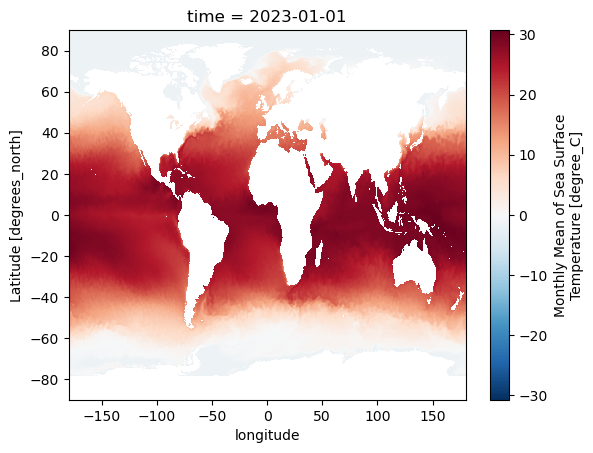

In [76]:
ds2['sst'].sel(time = "2023-01").plot()

In [60]:
ds1 = ds.sel(time = slice("2021-06", "2023-05"),
            latitude=slice(-10, 10), 
            longitude=slice(0, 360))
print(f"Size in GB: {ds1.nbytes / 1e6:.2f} MB")
ds1

Size in GB: 11.07 MB


<xarray.Dataset> Size: 11MB
Dimensions:    (time: 24, latitude: 80, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 192B 2021-06-01 2021-07-01 ... 2023-05-01
  * latitude   (latitude) float32 320B -9.875 -9.625 -9.375 ... 9.625 9.875
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
Data variables:
    sst        (time, latitude, longitude) float32 11MB ...
Attributes: (12/35)
    cdm_data_type:              Grid
    comment:                    Reynolds, et al.(2007) Daily High-Resolution-...
    Conventions:                CF-1.10, COARDS, ACDD-1.3
    creator_name:               NOAA/National Centers for Environmental Infor...
    creator_type:               group
    creator_url:                https://www.noaa.gov/
    ...                         ...
    testOutOfDate:              now-114days
    time_coverage_end:          2025-03-01T00:00:00Z
    time_coverage_start:        1981-09-01T00:00:00Z
    title:                      Sea Surface Tempearture, NOAA/NCEI Optimum In...
    version:                    Version 2.1
    Westernmost_Easting:        0.125

In [67]:
ds1.load()

<xarray.Dataset> Size: 100MB
Dimensions:    (time: 24, latitude: 720, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 192B 2021-06-01 2021-07-01 ... 2023-05-01
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
Data variables:
    sst        (time, latitude, longitude) float32 100MB nan nan ... -1.8 -1.8
Attributes: (12/35)
    cdm_data_type:              Grid
    comment:                    Reynolds, et al.(2007) Daily High-Resolution-...
    Conventions:                CF-1.10, COARDS, ACDD-1.3
    creator_name:               NOAA/National Centers for Environmental Infor...
    creator_type:               group
    creator_url:                https://www.noaa.gov/
    ...                         ...
    testOutOfDate:              now-114days
    time_coverage_end:          2025-03-01T00:00:00Z
    time_coverage_start:        1981-09-01T00:00:00Z
    title:                      Sea Surface Tempearture, NOAA/NCEI Optimum In...
    version:                    Version 2.1
    Westernmost_Easting:        0.125

In [68]:
ds2 = ds1.assign_coords(longitude = ((ds1.longitude + 180) % 360) - 180)
ds2

<xarray.Dataset> Size: 100MB
Dimensions:    (time: 24, latitude: 720, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 192B 2021-06-01 2021-07-01 ... 2023-05-01
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... -0.375 -0.125
Data variables:
    sst        (time, latitude, longitude) float32 100MB nan nan ... -1.8 -1.8
Attributes: (12/35)
    cdm_data_type:              Grid
    comment:                    Reynolds, et al.(2007) Daily High-Resolution-...
    Conventions:                CF-1.10, COARDS, ACDD-1.3
    creator_name:               NOAA/National Centers for Environmental Infor...
    creator_type:               group
    creator_url:                https://www.noaa.gov/
    ...                         ...
    testOutOfDate:              now-114days
    time_coverage_end:          2025-03-01T00:00:00Z
    time_coverage_start:        1981-09-01T00:00:00Z
    title:                      Sea Surface Tempearture, NOAA/NCEI Optimum In...
    version:                    Version 2.1
    Westernmost_Easting:        0.125

ValueError: The input coordinate is not sorted in increasing order along axis 0. This can lead to unexpected results. Consider calling the `sortby` method on the input DataArray. To plot data with categorical axes, consider using the `heatmap` function from the `seaborn` statistical plotting library.

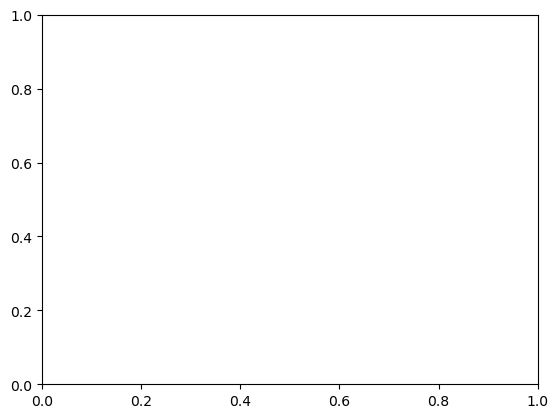

In [69]:
ds2['sst'].sel(time = "2021-06").plot()

In [45]:
(da.longitude + 180) % 360

<xarray.DataArray 'longitude' (longitude: 1440)> Size: 6kB
array([180.125, 180.375, 180.625, ..., 179.375, 179.625, 179.875],
      shape=(1440,), dtype=float32)
Coordinates:
    time       datetime64[ns] 8B 2023-05-01
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9

ValueError: The input coordinate is not sorted in increasing order along axis 0. This can lead to unexpected results. Consider calling the `sortby` method on the input DataArray. To plot data with categorical axes, consider using the `heatmap` function from the `seaborn` statistical plotting library.

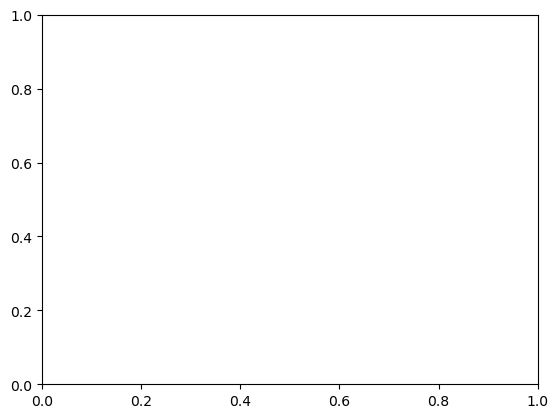

In [36]:
da.plot()

In [20]:
longitude_2 = np.array(da.longitude)
da.assign_coords(longitude_2=("longitude", longitude_2))
da

<xarray.DataArray 'sst' (latitude: 720, longitude: 1440)> Size: 4MB
[1036800 values with dtype=float32]
Coordinates:
    time       datetime64[ns] 8B 2023-05-01
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
Attributes: (12/13)
    actual_range:     [-1.8  32.14]
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    ioos_category:    Temperature
    level_desc:       Surface
    long_name:        Monthly Mean of Sea Surface Temperature
    ...               ...
    precision:        2.0
    standard_name:    sea_surface_temperature
    statistic:        Monthly Mean
    units:            degree_C
    valid_range:      [-3. 45.]
    var_desc:         Sea Surface Temperature

In [8]:
da.plot()

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

In [36]:
db = da.assign_coords(longitude = ((da.longitude + 180) % 360) - 180)
db

<xarray.Dataset> Size: 4MB
Dimensions:    (latitude: 720, longitude: 1440)
Coordinates:
    time       datetime64[ns] 8B 2023-05-01
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... -0.375 -0.125
Data variables:
    sst        (latitude, longitude) float32 4MB ...
Attributes: (12/35)
    cdm_data_type:              Grid
    comment:                    Reynolds, et al.(2007) Daily High-Resolution-...
    Conventions:                CF-1.10, COARDS, ACDD-1.3
    creator_name:               NOAA/National Centers for Environmental Infor...
    creator_type:               group
    creator_url:                https://www.noaa.gov/
    ...                         ...
    testOutOfDate:              now-114days
    time_coverage_end:          2025-03-01T00:00:00Z
    time_coverage_start:        1981-09-01T00:00:00Z
    title:                      Sea Surface Tempearture, NOAA/NCEI Optimum In...
    version:                    Version 2.1
    Westernmost_Easting:        0.125

In [38]:
db.longitude

<xarray.DataArray 'longitude' (longitude: 1440)> Size: 6kB
array([ 0.125,  0.375,  0.625, ..., -0.625, -0.375, -0.125],
      shape=(1440,), dtype=float32)
Coordinates:
    time       datetime64[ns] 8B 2023-05-01
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... -0.375 -0.125

In [33]:
da = ds
#da.assign_coords(longitude=(((da.longitude + 180) % 360) - 180))
da.coords['longitude'] = (da.coords['longitude'] + 180) % 360 - 180

In [30]:
ds.coords

Coordinates:
  * time       (time) datetime64[ns] 4kB 1981-09-01 1981-10-01 ... 2025-03-01
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9

ValueError: The input coordinate is not sorted in increasing order along axis 0. This can lead to unexpected results. Consider calling the `sortby` method on the input DataArray. To plot data with categorical axes, consider using the `heatmap` function from the `seaborn` statistical plotting library.

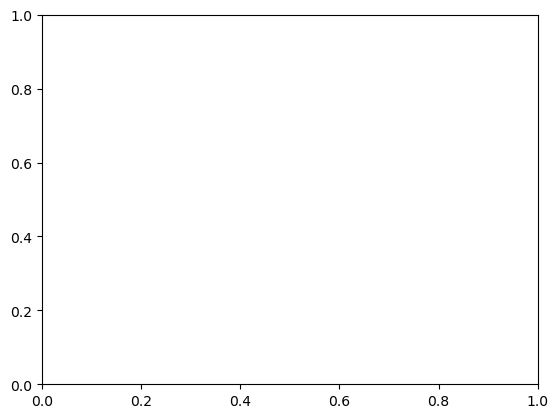

In [32]:
da['sst'].sel(time="2023-05-01").plot()

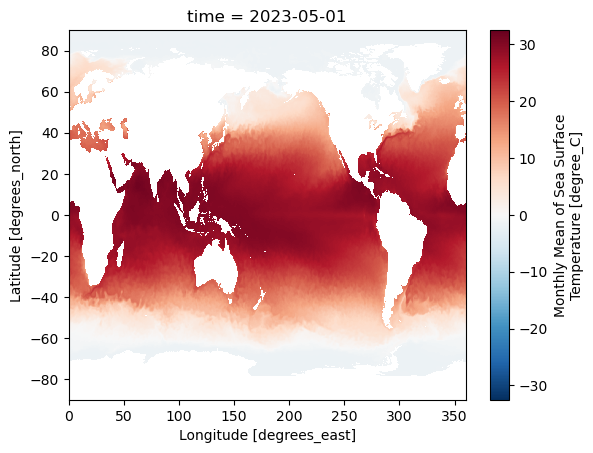

In [19]:
ds['sst'].sel(time="2023-05-01").plot()

# Change longitudes to -180 to +180 so that you can plot across the prime meridian

See https://docs.xarray.dev/en/stable/generated/xarray.Dataset.assign_coords.html

Example:

lon_min = -10

lon_min = ((lon_min + 180) % 360)

lon_min

In [23]:
(179+180) % 360 - 180

179

In [8]:
ds = ds.assign_coords(longitude = (ds.longitude + 180) % 360)
#ds = ds.assign_coords(longitude = ((ds.longitude + 180) % 360) - 360)
print(ds.latitude.min())
print(ds.latitude.max())
print(ds.longitude.min())
print(ds.longitude.max())

<xarray.DataArray 'latitude' ()> Size: 4B
array(-89.875, dtype=float32)
<xarray.DataArray 'latitude' ()> Size: 4B
array(89.875, dtype=float32)
<xarray.DataArray 'longitude' ()> Size: 4B
array(0.125, dtype=float32)
<xarray.DataArray 'longitude' ()> Size: 4B
array(359.875, dtype=float32)


# Set parameters

In [29]:
colormap = 'RdBu_r'

date_range = ("1982-01-01", "2024-12-01")
lat_min = -10
lat_max = 20
lon_min = 0 #-30 + 360
lon_max = 10

#create smaller box for the local region
lat_min_sm = 12.6
lat_max_sm = 16.6
lon_min_sm = -19.6; lon_min_sm = lon_min_sm + 360
lon_max_sm = -15.6; lon_max_sm = lon_max_sm + 360

#input deployment locations
#site 1 deployment 1
deployment0101_lat = 14.616
deployment0101_lon = -17.631 + 360

#site 1, deployment 2
deployment0102_lat =14.615
deployment0102_lon =-17.630 + 360

#site 1, deployment 3
deployment0103_lat = 14.618
deployment0103_lon = -17.628 + 360

#site 1, deployment 4
deployment0104_lat = 14.618
deployment0104_lon = -17.628 + 360

#site 2, deployments 1 & 2
deployment020102_lat = 14.742
deployment020102_lon = -17.636 + 360

#region around recorders
rec_lat_min = 12 
rec_lat_max = 17
rec_lon_min = -12 + 360
rec_lon_max = -20 + 360

#CVI coords
CVI_lat_min = 14
CVI_lat_max = 18
CVI_lon_min = -27 + 360
CVI_lon_max = -21 + 360

#GoG Gulf of Guinea
GoG_lat_min = -10
GoG_lat_max = 7
GoG_lon_min = 6
GoG_lon_max = 15

# Visualize the regions and stations

In [ ]:
dc = ds['sst'].sel(latitude=slice(lat_min, lat_max), 
                   longitude=slice(lon_min, lon_max), 
                   time=slice(date_range[0], date_range[1]))



dc.plot(time = "2023-05-01")
#dc.sel(time = "2023-05-01").plot(vmin = 20, vmax = 30)

# Load subset of global SST dataset and create a data cube

In [88]:
dc = ds['sst'].sel(latitude=slice(lat_min, lat_max), 
                   longitude=slice(lon_min, lon_max), 
                   time=slice(date_range[0], date_range[1]))
print(f"Size in MB: {dc.nbytes / 1e6:.2f} MB")
print(dc.shape)
dc

dc_sm = ds['sst'].sel(latitude=slice(lat_min_sm, lat_max_sm), 
                   longitude=slice(lon_min_sm, lon_max_sm), 
                   time=slice(date_range[0], date_range[1]))
print(f"Size in MB: {dc.nbytes / 1e6:.2f} MB")
print(dc.shape)
dc_sm

Size in MB: 49.54 MB
(516, 120, 200)
Size in MB: 49.54 MB
(516, 120, 200)


<xarray.DataArray 'sst' (time: 516, latitude: 16, longitude: 16)> Size: 528kB
[132096 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 4kB 1982-01-01 1982-02-01 ... 2024-12-01
  * latitude   (latitude) float32 64B 12.62 12.88 13.12 ... 15.88 16.12 16.38
  * longitude  (longitude) float32 64B 340.6 340.9 341.1 ... 343.9 344.1 344.4
Attributes: (12/13)
    actual_range:     [-1.8  32.14]
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    ioos_category:    Temperature
    level_desc:       Surface
    long_name:        Monthly Mean of Sea Surface Temperature
    ...               ...
    precision:        2.0
    standard_name:    sea_surface_temperature
    statistic:        Monthly Mean
    units:            degree_C
    valid_range:      [-3. 45.]
    var_desc:         Sea Surface Temperature

## View the region and a bit of data

In [9]:
ds.sel(time = "2023-05-01").plot(vmin = 20, vmax = 30)

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

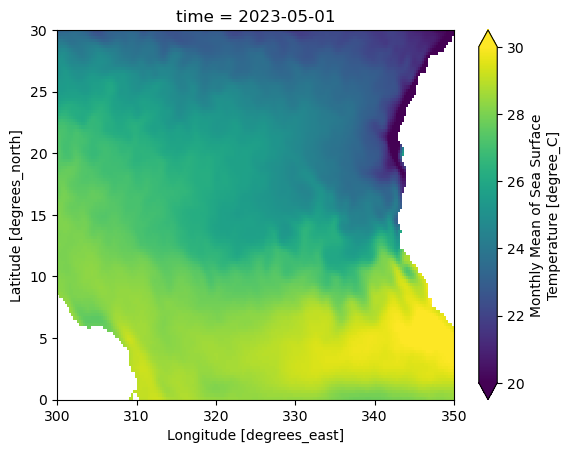

In [89]:
dc.sel(time = "2023-05-01").plot(vmin = 20, vmax = 30)

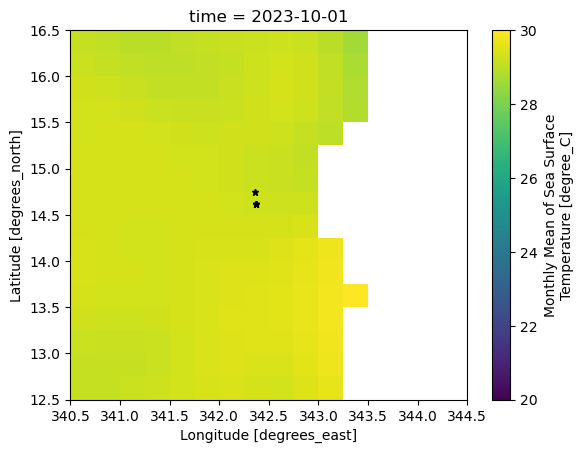

In [90]:
fig, ax = plt.subplots()
dc_sm.sel(time = "2023-10-01").plot(vmin = 20, vmax = 30)
ax.plot(deployment0101_lon, deployment0101_lat, marker='*', color='k', markersize=5)
ax.plot(deployment0101_lon, deployment0102_lat, marker='*', color='k', markersize=5)
ax.plot(deployment0101_lon, deployment0103_lat, marker='*', color='k', markersize=5)
ax.plot(deployment0101_lon, deployment0104_lat, marker='*', color='k', markersize=5)
ax.plot(deployment020102_lon, deployment020102_lat, marker='*', color='k', markersize=5)

# Code to hang onto

# Create monthly climatology and monthly anomalies
### climatology will have one layer for each month
### anomalies will be the difference between climatology and every month in dc

In [91]:
climatology = dc.groupby("time.month").mean("time")
dc_anom = dc.groupby("time.month") - climatology
print(climatology.shape)
print(dc_anom.shape)

(12, 120, 200)
(516, 120, 200)


# Plots monthly means over space, and climatology

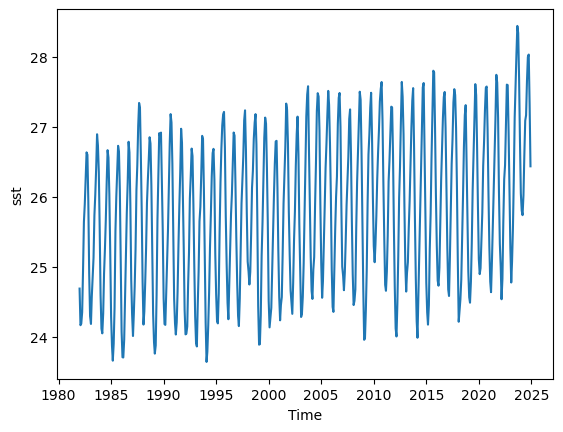

In [9]:
#average over all space against time (monthly means over the domain)
dc.mean(dim=['latitude', 'longitude']).plot();

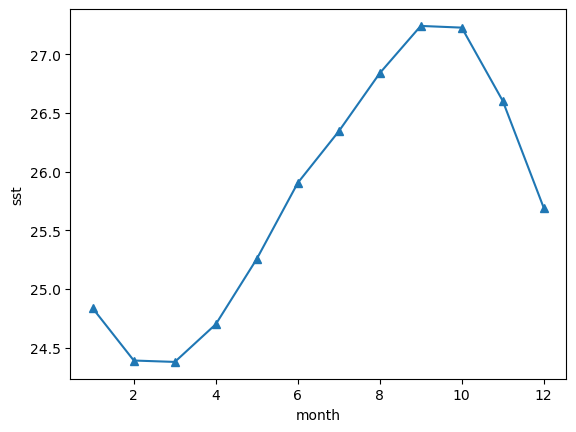

In [10]:
climatology.mean(dim = ['latitude','longitude']).plot(marker = "^")

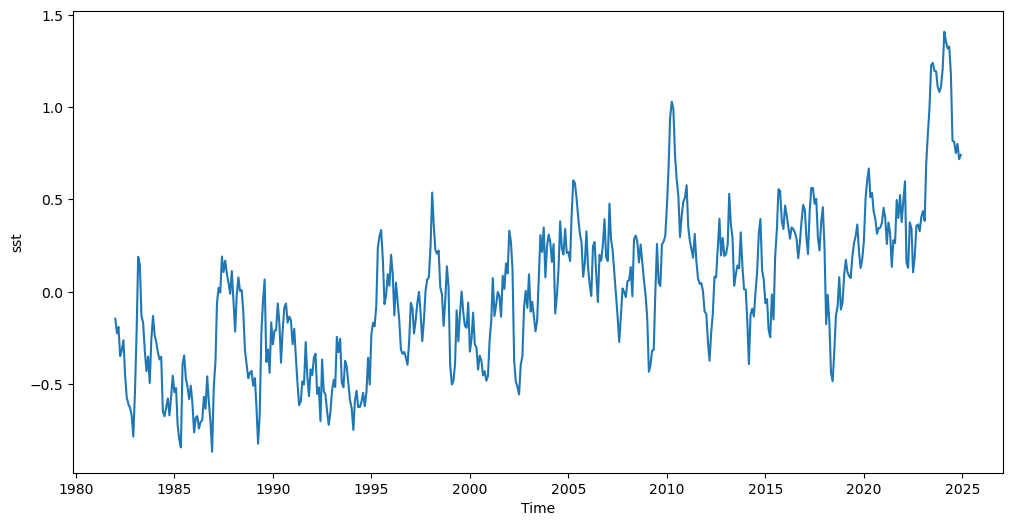

In [11]:
dc_anom.mean(dim = ['latitude','longitude']).plot(aspect=2, size=6)

In [12]:
dc_anom

<xarray.DataArray 'sst' (time: 516, latitude: 120, longitude: 200)> Size: 50MB
array([[[           nan,            nan,            nan, ...,
          1.1224365e-01,  1.6450882e-01,  1.5072823e-01],
        [           nan,            nan,            nan, ...,
          1.3668251e-01,  1.7908478e-01,  2.0002174e-01],
        [           nan,            nan,            nan, ...,
          1.4057732e-01,  1.5922737e-01,  1.8239212e-01],
        ...,
        [-1.1525517e+00, -1.2150249e+00, -1.1841183e+00, ...,
          4.7068977e-01,  5.3919601e-01,            nan],
        [-1.3267956e+00, -1.3024826e+00, -1.2002621e+00, ...,
          2.9590225e-01,  3.0013466e-01,  2.6963234e-01],
        [-1.4229107e+00, -1.3423862e+00, -1.2039547e+00, ...,
          2.8579903e-01,  2.0708847e-01,  1.7282867e-01]],

       [[           nan,            nan,            nan, ...,
          5.8219910e-02, -6.8023682e-02, -1.5277863e-01],
        [           nan,            nan,            nan, ...,
          1.1357498e-01, -2.7345657e-02, -1.1412048e-01],
        [           nan,            nan,            nan, ...,
          1.3836288e-01,  1.7812729e-02, -3.8295746e-02],
...
          1.1235580e+00,  9.2430305e-01,            nan],
        [ 2.5712395e-01,  2.7862930e-01,  2.8559685e-01, ...,
          1.2547531e+00,  1.0314960e+00,  8.7175941e-01],
        [ 8.3154678e-02,  1.5973663e-01,  2.3732567e-01, ...,
          1.2979450e+00,  1.1113110e+00,  9.1883659e-01]],

       [[           nan,            nan,            nan, ...,
          9.3811798e-01,  9.5842361e-01,  9.6728516e-01],
        [           nan,            nan,            nan, ...,
          9.4605446e-01,  9.5600891e-01,  9.6070480e-01],
        [           nan,            nan,            nan, ...,
          9.6322632e-01,  9.6576118e-01,  9.5768929e-01],
        ...,
        [ 1.9001007e-02, -4.9699783e-02, -6.2339783e-02, ...,
          1.0804958e+00,  9.1477776e-01,            nan],
        [ 3.5274506e-02, -4.5768738e-02, -7.4419022e-02, ...,
          1.2554531e+00,  1.0862942e+00,  9.5129013e-01],
        [-7.4253082e-02, -1.4702225e-01, -1.7306709e-01, ...,
          1.4428883e+00,  1.3380795e+00,  1.1931267e+00]]],
      shape=(516, 120, 200), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1982-01-01 1982-02-01 ... 2024-12-01
  * latitude   (latitude) float32 480B 0.125 0.375 0.625 ... 29.38 29.62 29.88
  * longitude  (longitude) float32 800B 300.1 300.4 300.6 ... 349.4 349.6 349.9
    month      (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

# Plot the anomaly as a time series 

## Plot continuous subset of the timeseries

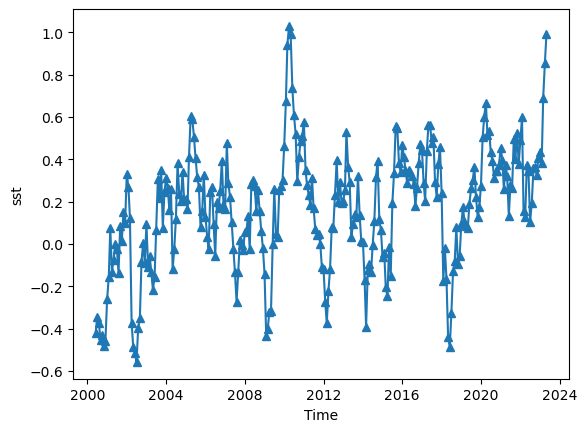

In [13]:
t1 = '2000-06-01'; t2 = '2023-05-01'
ts = dc_anom.sel(time=slice(t1, t2)).mean(dim = ['latitude','longitude'])
ts.plot(marker = '^')

## Plot mean temperature anomalies for a particular month

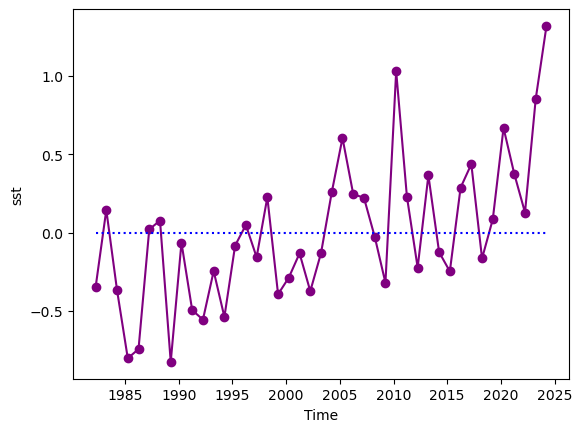

In [64]:
#plot all temps for month = m
m = 4
dc_anom_june = dc_anom.sel(time = (dc_anom.time.dt.month == m))
dc_anom_june_mean = dc_anom_june.mean(dim = ['latitude', 'longitude'])
dc_anom_june_mean

z = dc_anom_june_mean*0

fig, ax = plt.subplots()
dc_anom_june_mean.plot(color="purple", marker="o")
z.plot(linestyle = ':', color = "blue" )

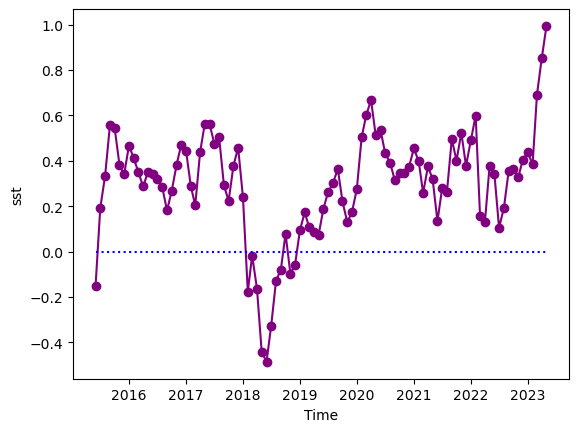

In [65]:
t1 = '2015-06-01'; t2 = '2023-05-01'
ts = dc_anom.sel(time=slice(t1, t2)).mean(dim = ['latitude','longitude'])

z = ts*0

fig, ax = plt.subplots()
ts.plot(color="purple", marker="o")
z.plot(linestyle = ':', color = "blue" )

# Plot a particular time period

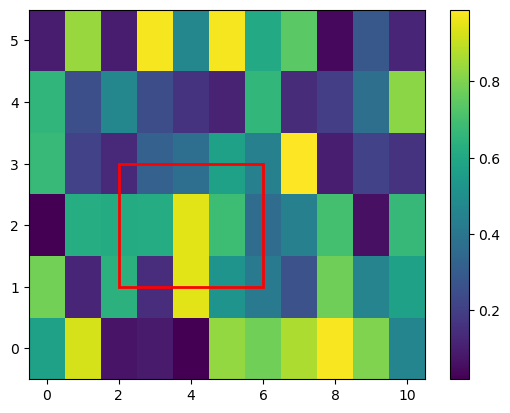

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create sample data
x = np.linspace(0, 10, 11)
y = np.linspace(0, 5, 6)
X, Y = np.meshgrid(x, y)
Z = np.random.rand(len(y), len(x))

# Create pcolormesh plot
fig, ax = plt.subplots()
mesh = ax.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')

# Add a rectangle on top
# Arguments: (x, y), width, height
rect = patches.Rectangle((2, 1), 4, 2, linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)

# Add colorbar and show
plt.colorbar(mesh, ax=ax)
plt.show()

In [67]:
x

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

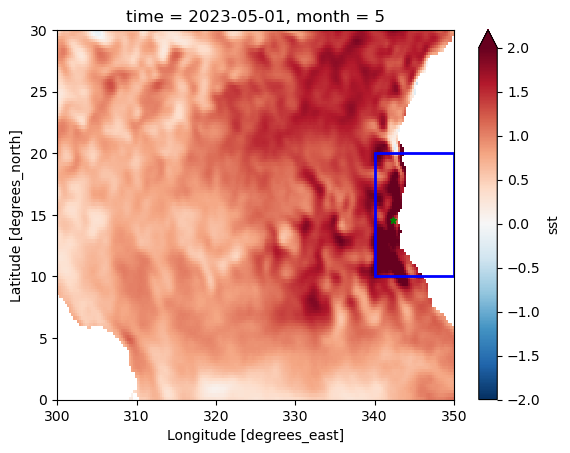

In [78]:
t = "2023-05-01"; #date

# Add a rectangle on top
# Arguments: (x, y), width, height
rect = patches.Rectangle((lon_min_sm, lat_min_sm), 10, 10, linewidth=2, edgecolor='blue', facecolor='none')

fig, ax = plt.subplots()
dc_anom.sel(time = t).plot(cmap = colormap, vmin = -2, vmax = 2)
ax.add_patch(rect)

ax.plot(deployment0101_lon, deployment0101_lat, marker='*', color='g', markersize=5)

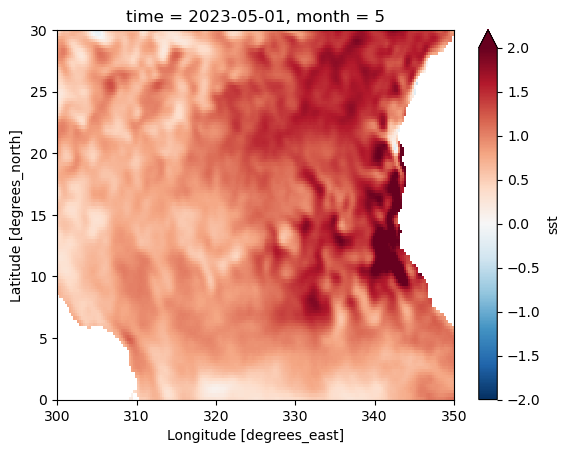

In [47]:
t = "2023-05-01"; #date
dc_anom.sel(time = t).plot(cmap = colormap, vmin = -2, vmax = 2)

# Produce monthly anomalies by a different method, then compare the two of them
## climatology2 is the second climatology

In [80]:
#dc.groupby?

#print(dc.time.dt)
#print(dc.time.dt.month)

#gb = ds.sst.groupby(ds.time.dt.month)
#gb

gb = dc.groupby('time.month')
gb
type(gb)

#there are only 2 things inside this particular groupby, so you can choose any name you want
for group_name, group_da in gb:
    # stop iterating after the first loop
    break 
print(group_name)
group_da

#gb.map(np.mean)
climatology2 = gb.mean(dim='time')
climatology2.shape

1


(12, 80, 80)

In [81]:
climatology2

<xarray.DataArray 'sst' (month: 12, latitude: 80, longitude: 80)> Size: 307kB
array([[[27.401087, 27.38976 , 27.37525 , ..., 27.218723, 27.245491,
         27.272175],
        [27.428806, 27.412708, 27.400051, ..., 27.388477, 27.415108,
         27.439978],
        [27.464703, 27.447989, 27.436024, ..., 27.549099, 27.56787 ,
         27.589865],
        ...,
        [23.285814, 23.24093 , 23.194351, ...,       nan,       nan,
               nan],
        [23.252151, 23.207748, 23.166632, ...,       nan,       nan,
               nan],
        [23.218649, 23.17366 , 23.136662, ...,       nan,       nan,
               nan]],

       [[27.610943, 27.623043, 27.640762, ..., 27.746778, 27.771595,
         27.78992 ],
        [27.619318, 27.63053 , 27.648956, ..., 27.878567, 27.904488,
         27.923405],
        [27.629192, 27.638575, 27.654356, ..., 28.009136, 28.033972,
         28.05151 ],
...
        [25.676697, 25.649658, 25.631031, ...,       nan,       nan,
               nan],
        [25.633217, 25.60921 , 25.58982 , ...,       nan,       nan,
               nan],
        [25.5961  , 25.573294, 25.549969, ...,       nan,       nan,
               nan]],

       [[27.11531 , 27.102047, 27.08318 , ..., 26.570269, 26.599962,
         26.633038],
        [27.175041, 27.162077, 27.146069, ..., 26.793945, 26.823023,
         26.856714],
        [27.24811 , 27.238049, 27.227125, ..., 26.985483, 27.014238,
         27.05102 ],
        ...,
        [24.538124, 24.511763, 24.477629, ...,       nan,       nan,
               nan],
        [24.499317, 24.471066, 24.436346, ...,       nan,       nan,
               nan],
        [24.464613, 24.4342  , 24.396984, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 320B 0.125 0.375 0.625 ... 19.38 19.62 19.88
  * longitude  (longitude) float32 320B 330.1 330.4 330.6 ... 349.4 349.6 349.9
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes: (12/13)
    actual_range:     [-1.8  32.14]
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    ioos_category:    Temperature
    level_desc:       Surface
    long_name:        Monthly Mean of Sea Surface Temperature
    ...               ...
    precision:        2.0
    standard_name:    sea_surface_temperature
    statistic:        Monthly Mean
    units:            degree_C
    valid_range:      [-3. 45.]
    var_desc:         Sea Surface Temperature

# Plot two climatologies next to one another

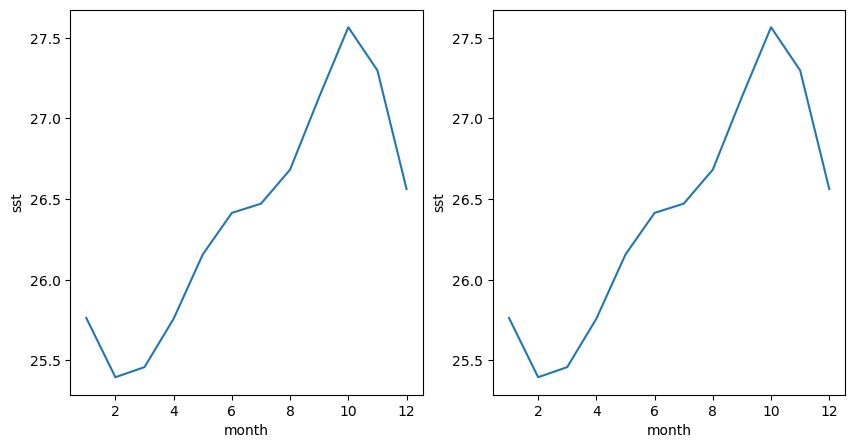

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
climatology.mean(dim = ['latitude','longitude']).plot(ax = axes[0])
climatology2.mean(dim=['latitude', 'longitude']).plot(ax=axes[1])

# Plot a single anomaly map from each method, to compare

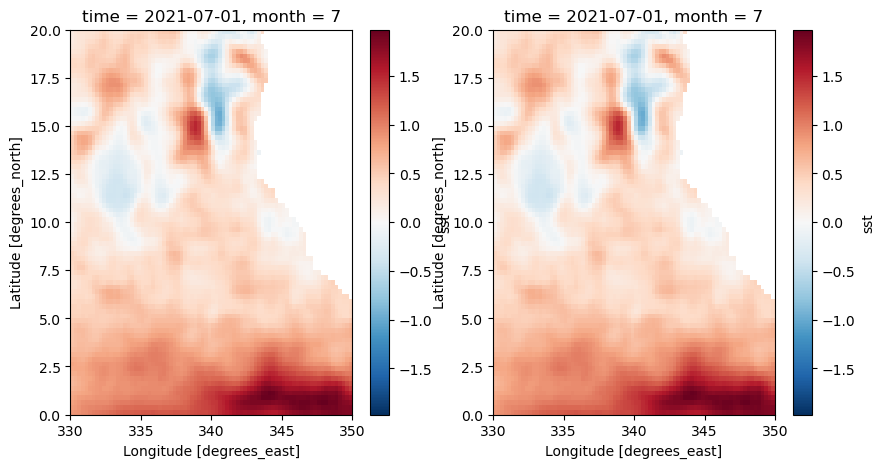

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
t = "2021-07-01"; m = 7; #date and month
dc_anom.sel(time = t).plot(ax = axes[0])
(dc.sel(time = t) - climatology2.sel(month = m)).plot(ax=axes[1])